# Avazu - Click-Through Rate Prediction

Julia Kang - jkang613@gmail.com - AMLI 2019 - Mills College

**References:**  
Original Source: https://www.kaggle.com/c/avazu-ctr-prediction   
Sample Data Preprocessing: https://towardsdatascience.com/mobile-ads-click-through-rate-ctr-prediction-44fdac40c6ff  
Wining Solution: https://www.csie.ntu.edu.tw/~r01922136/slides/kaggle-avazu.pdf   
Sample Logisitic Reg: https://turi.com/learn/gallery/notebooks/click_through_rate_prediction_intro.html  
Another Medium post: https://becominghuman.ai/predicting-click-probabilities-on-a-leading-advertising-platform-7582633e6e78  
Logistic Reg: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8   
Random Forests - Tuning: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d   




# Import Libraries

In [355]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import psutil
import random
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
# from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from math import sqrt #for RMSE
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import roc_curve, auc


# #to visual random forest
# import pydotplus
# from IPython.display import Image  
# from sklearn.externals.six import StringIO  



# Load in Data

In [6]:
#read in the original csv file

# df = pd.read_csv('../data/train_sample.csv')

# df.head()

In [7]:
# Check the number of cores and memory usage
# num_cores = mp.cpu_count()
# print("This kernel has ",num_cores,"cores and you can find the information regarding the memory usage:",psutil.virtual_memory())

In [8]:
# p = 0.01  # 1% of the lines
# # keep the header, then take only 1% of lines
# # if random from [0,1] interval is greater than 0.01 the row will be skipped
# filename = '../data/train_ds.csv'

# df_new = pd.read_csv(
#          filename,
#          header=0, 
#          skiprows=lambda i: i>0 and random.random() > p
# )


# IN THE FUTURE: WE CAN STRATIFY/CREATE SUBSETS BASED ON SPECIFIC FEATURES

In [9]:
#view the shape of the randomly selected sample we generated
# df_new.shape

In [10]:
# df_new.head()

In [11]:
#create new csv that is randomly sampled from originally training set that has 404,410 rows - it's been moved to the
#data folder

# df_new.to_csv("rand_sample_csv.csv")

In [120]:
# #read the csv file we created and make sure to pass the 'hour' column as the correct dtype

sub_df = pd.read_csv('rand_sample_csv.csv', parse_dates=['hour'])

In [121]:
sub_df.head() #preview the data

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,...,1,0,20352,320,50,2333,0,39,-1,157
1,1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15706,320,50,1722,0,35,-1,79
2,2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,...,0,0,21692,216,36,2497,3,43,100151,42
3,3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15705,320,50,1722,0,35,-1,79
4,4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15701,320,50,1722,0,35,-1,79


In [122]:
#Drop the original indexing column known as "Unnamed: 0"
sub_df.columns #read through the column names so we can delete the first column since it is useless
sub_df = sub_df.drop('Unnamed: 0', axis = 1) 

In [123]:
sub_df.head() #check to make sure the column deletion was successful

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20352,320,50,2333,0,39,-1,157
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,-1,79
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,0,21692,216,36,2497,3,43,100151,42
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15705,320,50,1722,0,35,-1,79
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,-1,79


# Feature Engineering

In [124]:
# feature engineering - work on the hour column and separate the hour and time into new columns
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
sub_df['new_hour'] = sub_df['hour'].apply(parse_date)
# sub_df['new_hour']

In [125]:
sub_df['new_date'] = [d.date() for d in sub_df['new_hour']]
sub_df['new_time'] = [d.time() for d in sub_df['new_hour']]

In [126]:
day_of_week = lambda val : val.weekday()
sub_df['day_of_week'] = sub_df['new_date'].apply(day_of_week) #Monday is 0 and Sunday is 6

#IN THE FUTURE LETS USE ONE HOT ENCODER

In [127]:
sub_df.head() #check if column creation was successful

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C16,C17,C18,C19,C20,C21,new_hour,new_date,new_time,day_of_week
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,50,2333,0,39,-1,157,2014-10-21,2014-10-21,00:00:00,1
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,-1,79,2014-10-21,2014-10-21,00:00:00,1
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,36,2497,3,43,100151,42,2014-10-21,2014-10-21,00:00:00,1
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,-1,79,2014-10-21,2014-10-21,00:00:00,1
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,-1,79,2014-10-21,2014-10-21,00:00:00,1


In [128]:
sub_df = sub_df.drop('new_hour', axis = 1) #drop the 'new_hour' column do eliminate redundancy 

In [129]:
sub_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,1
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,216,36,2497,3,43,100151,42,2014-10-21,00:00:00,1
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1


# ***RUN THE CODE FROM HERE:  ***

In [139]:
# sub_df.to_csv("rand_sample_eng.csv") #export as a csv so save for future use

sub_df = pd.read_csv('rand_sample_eng.csv')

In [186]:
# sub_df = sub_df.drop('hour', axis = 1) 
sub_df = sub_df.drop('Unnamed: 0', axis = 1) 

In [187]:
sub_df.head() #ad id is unique to each row
# len(sub_df)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,1
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,216,36,2497,3,43,100151,42,2014-10-21,00:00:00,1
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1


In [188]:
len(sub_df['id'].unique())

404410

In [189]:
#check for null and empty values - There are none
sub_df.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
new_date            0
new_time            0
day_of_week         0
dtype: int64

# Clicks

In [190]:
#see what percentage of people click and what percentage of people do not click
# click = 16.9991% no click = 83.0009%
sub_df['click'].value_counts()/404410

0    0.830009
1    0.169991
Name: click, dtype: float64

In [191]:
#Find the start and end date of the data
print(sub_df['new_date'].min(), sub_df['new_date'].max())

2014-10-21 2014-10-30


**Note:** Our dataset ranges from 10/21/2014 to 10/30/2014. It spans a total of 10 days.

### Clicks per hour

In [192]:
clicks = sub_df.groupby('hour').agg({'click':'sum'})
# clicks

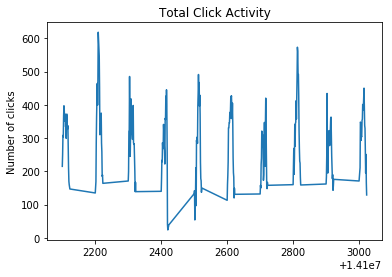

In [193]:
plt.plot(clicks)
plt.ylabel('Number of clicks')
plt.title('Total Click Activity')
plt.show()
#Change x-axis

**Summary:** From our graph we that user activity fluctuated greated throughout the day

In [194]:
clicks_details = sub_df.groupby(['new_date','new_time']).size().unstack()
clicks_details

new_time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
new_date,,,,,,,,,,,,,,,,,,,,,
2014-10-21,1182,1400,2061,1875,2611,2673,2395,2077,2116,2282,...,1786,1767,1767,1668,1527,1246,1062,922,830,744
2014-10-22,794,926,1011,1376,2020,2892,2881,2244,3227,4442,...,1798,1823,1886,1984,2113,1772,1491,1215,1078,938
2014-10-23,879,1052,1533,1777,2777,2257,1400,1563,2381,1811,...,1745,2477,1690,1601,1494,1394,1355,1224,1049,895
2014-10-24,789,927,1213,1228,1644,1664,1644,1769,1676,1725,...,2160,2029,2624,2513,1636,310,200,238,144,246
2014-10-25,726,795,402,675,762,1209,514,1374,1546,1795,...,2394,2515,2105,2111,1930,1215,1004,896,863,800
2014-10-26,720,828,991,1106,1507,1725,1773,1922,1917,2090,...,2323,2013,1980,1873,1530,1185,1014,815,879,809
2014-10-27,646,738,847,1190,1348,1730,1807,1692,1607,1522,...,1062,1075,1788,2356,2089,1590,1016,963,950,871
2014-10-28,811,1040,1750,1178,1376,1753,1804,2085,2858,3278,...,3898,2817,2849,2886,2363,1991,1682,1582,1253,1167
2014-10-29,1000,1176,1404,2305,1588,1299,1397,2317,2034,1921,...,2255,2028,1825,1588,1369,1241,1157,954,942,977


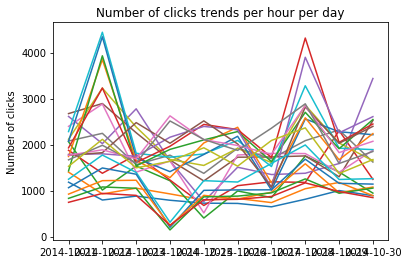

In [195]:
plt.plot(clicks_details)
plt.figsize=(24,12)
plt.ylabel('Number of clicks')
plt.title('Number of clicks trends per hour per day') 
plt.show()

In [196]:
clicks_per_hour = sub_df.groupby('new_time').agg({'click': 'sum'})

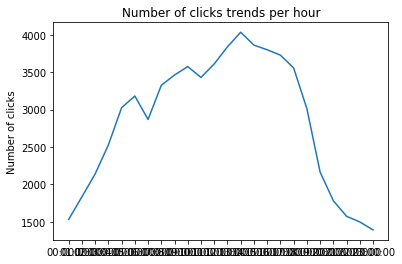

In [197]:
plt.plot(clicks_per_hour)
plt.ylabel('Number of clicks')
plt.title('Number of clicks trends per hour') 
plt.figsize=(12,6)

**Summary:** The greatest click activity occurs mid-day around 12pm.

### Clicks per Day of the Week

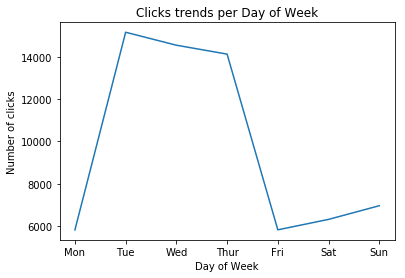

In [198]:
clicks_per_dow = sub_df.groupby('day_of_week').agg({'click':'sum'})
plt.plot(clicks_per_dow)
x = ['Mon', 'Tue', 'Wed','Thur','Fri','Sat','Sun']
plt.xticks(range(7), x)

plt.ylabel('Number of clicks')
plt.xlabel('Day of Week')
plt.title('Clicks trends per Day of Week') 
plt.figsize=(12,6)
plt.show()

**Summary:** Ads experience the most activity Tuesday-Thursday and the least amount of activity Monday and Friday. 

# Impressions

### Impressions by Hour

In [199]:
# ORDER MATTERS
click_per_view_per_hour = sub_df.groupby(['new_time','click']).size().unstack()
click_per_view_per_hour['total'] = click_per_view_per_hour.sum(axis=1)
# click_per_view_per_hour

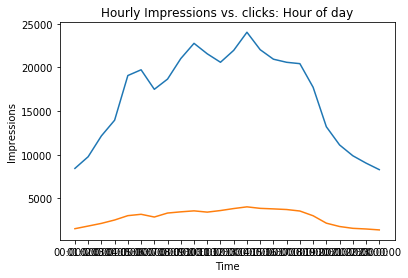

In [200]:
# plt.plot(click_per_view_per_hour, figsize = (12,6))
plt.plot(click_per_view_per_hour['total'])
plt.plot(click_per_view_per_hour[1])
plt.ylabel('Impressions')
plt.xlabel('Time')
plt.title('Hourly Impressions vs. clicks: Hour of day')
plt.show()

#Can't get it to a bar graph...?

**Summary:** From our graph we can see that Impressions and Clicks are generally lower around midnight, and high during noon.

### Impressions by day of week

In [201]:
# ORDER MATTERS
click_per_view_per_dow = sub_df.groupby(['day_of_week','click']).size().unstack()
click_per_view_per_dow['total'] = click_per_view_per_dow.sum(axis=1)
click_per_view_per_dow

click,0,1,total
day_of_week,,,
0,26597,5816,32413
1,78575,15161,93736
2,77396,14548,91944
3,67107,14127,81234
4,27110,5820,32930
5,27675,6314,33989
6,31204,6960,38164


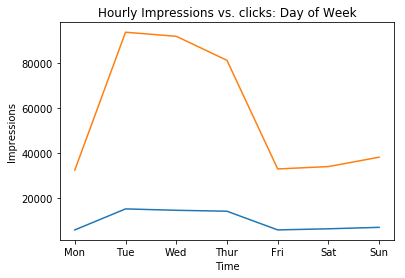

In [202]:
# plt.plot(click_per_view_per_hour, figsize = (12,6))
plt.plot(click_per_view_per_dow[1])
plt.plot(click_per_view_per_dow['total'])
x = ['Mon', 'Tue', 'Wed','Thur','Fri','Sat','Sun']
plt.xticks(range(7), x)
plt.ylabel('Impressions')
plt.xlabel('Time')
plt.title('Hourly Impressions vs. clicks: Day of Week')
plt.show()


# CTR

### CTR by Hour

**Formula** CTR = Clicks : Impressions

In [203]:
CTR_per_hourofday = click_per_view_per_hour[1]/click_per_view_per_hour['total']
CTR_per_hourofday

new_time
00:00:00    0.181624
01:00:00    0.187679
02:00:00    0.176045
03:00:00    0.181095
04:00:00    0.158634
05:00:00    0.161251
06:00:00    0.163961
07:00:00    0.178106
08:00:00    0.164779
09:00:00    0.157057
10:00:00    0.159067
11:00:00    0.175345
12:00:00    0.174858
13:00:00    0.167860
14:00:00    0.175277
15:00:00    0.181423
16:00:00    0.181054
17:00:00    0.174066
18:00:00    0.169986
19:00:00    0.163978
20:00:00    0.160237
21:00:00    0.159231
22:00:00    0.165800
23:00:00    0.167852
dtype: float64

Text(0.5,1,'CTR per Hour of Day')

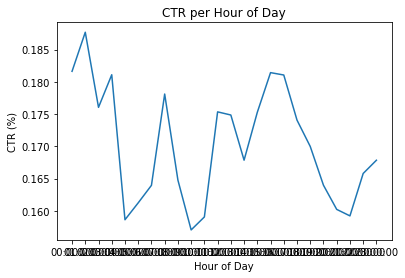

In [204]:
plt.plot(CTR_per_hourofday)
plt.ylabel('CTR (%)')
plt.xlabel('Hour of Day')
plt.title('CTR per Hour of Day')

**Summary:** From our graph we can see that CTR is highest at 12-3am, 11-12am, 3-4pm.

### CTR by Day of Week

In [205]:
CTR_per_dow = click_per_view_per_dow[1]/click_per_view_per_dow['total']
CTR_per_dow

day_of_week
0    0.179434
1    0.161741
2    0.158227
3    0.173905
4    0.176739
5    0.185766
6    0.182371
dtype: float64

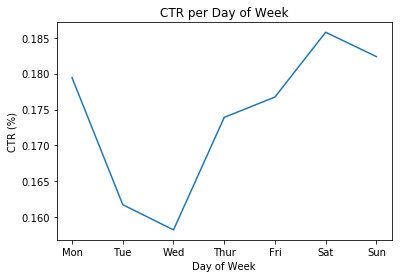

In [206]:
plt.plot(CTR_per_dow)
plt.ylabel('CTR (%)')
plt.xlabel('Day of Week')
plt.title('CTR per Day of Week')
x = ['Mon', 'Tue', 'Wed','Thur','Fri','Sat','Sun']
plt.xticks(range(7), x)
plt.show()

**Summary:** We can see very low CTR on Wednesdays and high CTR on Saturdays and Sunday. "Apparently, people have more time to click over the weekend."

# Exploring the Other Features

In [207]:
# Still need to explore banner position, device type, and C# and their relationship to CTR/

## Feature: C1, C14 - C21

In [208]:
#explore distribution of categorical features
print(sub_df['C1'].value_counts()/len(sub_df['C1']))
# print(sub_df['C14'].value_counts()/len(sub_df['C14'])) #LARGE VARIETY
print(sub_df['C15'].value_counts()/len(sub_df['C15']))
print(sub_df['C16'].value_counts()/len(sub_df['C16']))
# print(sub_df['C17'].value_counts()/len(sub_df['C17'])) #LARGE VARIETY
print(sub_df['C18'].value_counts()/len(sub_df['C18']))
# print(sub_df['C19'].value_counts()/len(sub_df['C19'])) #LARGE VARIETY
# print(sub_df['C20'].value_counts()/len(sub_df['C20'])) #LARGE VARIETY
# print(sub_df['C21'].value_counts()/len(sub_df['C21'])) #MEDIUM-LARGE VARIETY


1005    0.919290
1002    0.054583
1010    0.022064
1012    0.002816
1007    0.000853
1001    0.000257
1008    0.000136
Name: C1, dtype: float64
320     0.932484
300     0.057996
216     0.007586
728     0.001728
120     0.000082
1024    0.000052
480     0.000045
768     0.000027
Name: C15, dtype: float64
50      0.943122
250     0.044885
36      0.007586
480     0.002473
90      0.001728
20      0.000082
768     0.000052
320     0.000045
1024    0.000027
Name: C16, dtype: float64
0    0.418954
3    0.336683
2    0.177013
1    0.067350
Name: C18, dtype: float64


**Summary:** Most ads are C1 = 1005 (91.9290%), C15 = 320 (93.2484%), C16 = 50 (94.3122%), C18 = 0 (41.8954%), C20=-1 (46.8198%), C21 = 23 (22.0373%).

In [209]:
#Lets remove C14, C17, and C19 - These features do not seem to reveal much about the dataset.

# sub_df = sub_df.drop('C14', axis = 1) 
# sub_df = sub_df.drop('C17', axis = 1) 
# sub_df = sub_df.drop('C19', axis = 1) 


In [210]:
print(sub_df['device_type'].value_counts()/len(sub_df['device_type']))

1    0.923350
0    0.054583
4    0.018981
5    0.003084
2    0.000002
Name: device_type, dtype: float64


In [211]:
print(len(sub_df['device_id'].value_counts()))

64913


**Summary:** Most of the user activity is through using device type 1 (92.335%).

# Modeling!!!

### Encoding and Selecting Key Features

In [212]:
sub_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,1
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,216,36,2497,3,43,100151,42,2014-10-21,00:00:00,1
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1


In [257]:
# drop the columns with unqiue values or large volume of category types
# temp_sub_df = sub_df.drop(['id','hour','C14','C17','C19','site_id','site_domain','app_id','device_id'], axis =1)

temp_sub_df = sub_df
temp_sub_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,1
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,216,36,2497,3,43,100151,42,2014-10-21,00:00:00,1
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1


In [258]:
temp_sub_df.dtypes

id                  uint64
click                int64
hour                 int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
new_date            object
new_time            object
day_of_week          int64
dtype: object

In [259]:
# func = lambda val : val.hour
# train['hour'] = train['new_time'].apply(func)

# convert new_time column of type datetime to float and create new column called 'hour'
func = lambda val : (pd.datetime.strptime(val, '%H:%M:%S')).hour

temp_sub_df['hour'] = temp_sub_df['new_time'].apply(func)

In [254]:
temp_sub_df.head()
# train = train.drop(['hours'],axis=1)
# train.dtypes

,click,C1,banner_pos,site_category,app_domain,app_category,device_ip,device_model,device_type,device_conn_type,C15,C16,C18,C20,C21,new_date,new_time,day_of_week,hour
0,0,1005,0,3e814130,7801e8d9,07d7df22,8a308c73,3223bcfe,1,0,320,50,0,-1,157,2014-10-21,00:00:00,1,0
1,1,1005,0,28905ebd,7801e8d9,07d7df22,b2b14786,36d749e5,1,0,320,50,0,-1,79,2014-10-21,00:00:00,1,0
2,0,1002,0,50e219e0,7801e8d9,07d7df22,dbd0f760,1a4a9acf,0,0,216,36,3,100151,42,2014-10-21,00:00:00,1,0
3,0,1005,0,28905ebd,7801e8d9,07d7df22,37b3c191,edead9f4,1,0,320,50,0,-1,79,2014-10-21,00:00:00,1,0
4,0,1005,0,28905ebd,7801e8d9,07d7df22,488a9a3e,8a4875bd,1,0,320,50,0,-1,79,2014-10-21,00:00:00,1,0


In [218]:
# binary_classifier = linear_model.SGDClassifier(
#   random_state=2, # Specifying random state allow us to get repeatable outcomes
#   tol=1e-3, 
#   max_iter=500) 

# binary_classifier.fit(train[FEATURES], train['click'])

In [255]:
#Explore how many categories we have for each feature

len(temp_sub_df['device_type'].unique())

#141 app_domains
#21 site_categories
#25 app_categories
#217066 device_ips
#4170 device_models
#5 device_types


5

In [222]:
#Tried ONE HOT ENCODER - failed. Does not seem to like string inputs. Might have to use LabelEncoder first and then 
# ONE HOT ENCODER?? will revisit..

#Look into pandas.get_dummies

## When it comes to label encoding if you see trends with data then try shuffling the data and relabeling


# ohe_site_category = OneHotEncoder(categorical_features=[21])
# test = ohe_site_category.fit_transform(new_train['site_category']).toarray()

In [260]:
#create a new training dataset with the features we have selected - avoid overwriting the original training data

new_temp_sub_df = temp_sub_df[FEATURES]
new_temp_sub_df['click'] = temp_sub_df[TARGET]
new_temp_sub_df.dtypes

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


C1                   int64
banner_pos           int64
site_category       object
app_domain          object
app_category        object
device_type          int64
device_conn_type     int64
C15                  int64
C16                  int64
C18                  int64
C20                  int64
C21                  int64
day_of_week          int64
hour                 int64
click                int64
dtype: object

In [261]:
# Encoding for only 3 of the columns for the sake of time - using LabelEncoder()
# Create new columns for the encoded values so have the original values for reference

le_site_category = LabelEncoder()
temp_sub_df['enc_app_domain'] = le_site_category.fit_transform(temp_sub_df['app_domain'])
temp_sub_df['enc_site_category'] = le_site_category.fit_transform(temp_sub_df['site_category'])
temp_sub_df['enc_app_category'] = le_site_category.fit_transform(temp_sub_df['app_category'])

temp_sub_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C18,C19,C20,C21,new_date,new_time,day_of_week,enc_app_domain,enc_site_category,enc_app_category
0,10004510652136496837,0,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,0,39,-1,157,2014-10-21,00:00:00,1,65,3,0
1,10007164336863914220,1,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,35,-1,79,2014-10-21,00:00:00,1,65,1,0
2,10076859283156800622,0,0,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,3,43,100151,42,2014-10-21,00:00:00,1,65,5,0
3,10078825124049580646,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,35,-1,79,2014-10-21,00:00:00,1,65,1,0
4,10085233430943183912,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,35,-1,79,2014-10-21,00:00:00,1,65,1,0


In [264]:
# Features with the appropriate encoded column names to use to train our model

FEATURES = ['C1', 'banner_pos', 'enc_site_category', 'enc_app_domain',
       'enc_app_category', 'device_type',
       'device_conn_type', 'C15', 'C16', 'C18', 'C20', 'C21', 'day_of_week',
           'hour']
TARGET = ['click']

In [269]:
# split the data into test and train
train, test  = train_test_split(
  temp_sub_df,                        # split our digits dataframe
  stratify=temp_sub_df[TARGET],       # stratify by the 'click' column   
  test_size=0.2,                # 20% of the data should be held for testing
  random_state=42               # hard-coded random state for repeatability in the example
)

train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C18,C19,C20,C21,new_date,new_time,day_of_week,enc_app_domain,enc_site_category,enc_app_category
242327,17016179924101047753,0,4,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,3,297,100111,61,2014-10-27,04:00:00,0,75,5,3
274613,13362092218668200074,1,3,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,2,1063,-1,33,2014-10-28,03:00:00,1,65,19,0
323457,11914295786743937713,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,35,-1,51,2014-10-29,00:00:00,2,65,1,0
275743,12379328275205309290,0,4,1005,1,5ee41ff2,17d996e6,f028772b,ecad2386,7801e8d9,...,0,39,100081,221,2014-10-28,04:00:00,1,65,19,0
394154,15603282462457099589,0,16,1005,1,222acd54,de0f0f82,f028772b,ecad2386,7801e8d9,...,0,935,100075,48,2014-10-30,16:00:00,3,65,19,0


### Logisitic Regression -  Classification using ScikitLearn

In [270]:
# Start of LogisticRegression Model!!

model = LogisticRegression()
model.fit(train[FEATURES], train[TARGET]) #**** Make sure we are using the properly encoded features ***

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [349]:
# Seeing how our model performs on the SAME TRAINING DATA
predictions = model.predict(test[FEATURES])

In [352]:
#*******metrics******

cnf_matrix = metrics.confusion_matrix(test[TARGET], predictions)
print(cnf_matrix)
print()
print("Accuracy:",metrics.accuracy_score(test[TARGET], predictions))
print("Precision:",metrics.precision_score(test[TARGET], predictions))
print("Recall:",metrics.recall_score(test[TARGET], predictions))

[[66983   150]
 [13677    72]]

Accuracy: 0.8290472540243812
Precision: 0.32432432432432434
Recall: 0.005236744490508401


**Summary:** Looks like we have a pretty high number of incorrect predictions :(

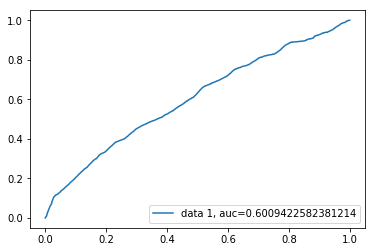

In [353]:
#ROC Curve

y_pred_proba = model.predict_proba(test[FEATURES])[::,1]
fpr, tpr, _ = metrics.roc_curve(test[TARGET],  y_pred_proba)
auc = metrics.roc_auc_score(test[TARGET], y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**Summary:** Yikes...

## Random Forests  - Classification using sklearn

In [342]:
#take preprocessed data from above for train and test set
train_features = np.array(train[FEATURES])
train_labels = np.array(train[TARGET])
test_features = np.array(test[FEATURES])
test_labels = np.array(test[TARGET])

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (323528, 14)
Training Labels Shape: (323528, 1)
Testing Features Shape: (80882, 14)
Testing Labels Shape: (80882, 1)


In [367]:
# Instantiate model with 10 decision trees - this will be our baseline model
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels.ravel()) #use ravel() - it flattens the array

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

In [345]:
#reshape predictions to have 1 column to later use to concatenate
predictions = predictions.reshape(80882,1)
print(predictions.shape)

(80882, 1)


In [346]:
#create dataframe that compares the actual vs predicted
results = pd.DataFrame(np.column_stack((test_labels, predictions)))

results

,0,1
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0
5,0,0
6,1,0
7,0,0
8,1,1
9,0,0


In [347]:
RMSE = sqrt(mean_squared_error(test_labels, predictions))
RMSE

# #RMSE: 0.4315343595981214 with n_estimators = 10

0.4315343595981214

**Summary:** Baseline error is still not great

We will use AUC (Area Under Curve) as the evaluation metric. Our target value is binary so it’s a binary classification problem. AUC is a good way for evaluation for this type of problems.

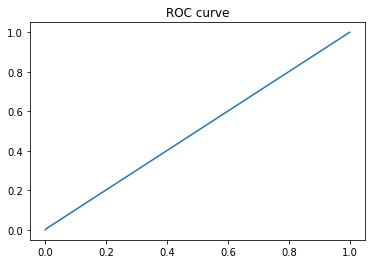

0.50150118695635

In [361]:
fpr, tpr, thresholds = metrics.roc_curve(test_labels, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.show()

roc_auc



**Summary:** Yikes....again

### Random Forest - Parameter Tuning

In [377]:
#try different n_estimators to see if we can find an optimal number of trees
n_estimators = [1, 10, 64, 225, 500]

rmse_results = []
auc_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, random_state = 42)
    rf.fit(train_features, train_labels.ravel())
    predictions = (rf.predict(test_features)).reshape(80882,1)
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, predictions)
    
    #metrics
    roc_auc = metrics.auc(fpr, tpr)
    auc_results.append(roc_auc)
    RMSE = sqrt(mean_squared_error(test_labels, predictions))
    rmse_results.append(RMSE)
    
    print(("Model where n_estimator = {} completed").format(estimator))

Model where n_estimator = 1 completed
Model where n_estimator = 10 completed
Model where n_estimator = 64 completed
Model where n_estimator = 225 completed
Model where n_estimator = 500 completed


In [378]:
rmse_results
# auc_results

[0.44603154691922864,
 0.4315343595981214,
 0.4303006229913365,
 0.4298406542623384,
 0.42935139755914326]

**Summary:** YIKESSS....RMSE IS SO BAD